In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Кастомный класс для загрузки датасета с изображениями
class MyDataset(Dataset):
    def __init__(self, root, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.all_files = []
        self.all_labels = []
        self.images = []
        self.classes = sorted(os.listdir(self.root))
        for i, class_name in enumerate(self.classes):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            self.all_files += files
            self.all_labels += [i] * len(files)
            if self.load_to_ram:
                self.images += self._load_images(files, i)

    def _load_images(self, image_files, label):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
            images += [image]
        return images

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
transform_cnn = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [4]:
# Реализация варианта сверточной нейронной сети
class FruitConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(  # (3, 224, 224)
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # (16, 224, 224)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),  # (16, 112, 112)
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  #  (32, 112, 112)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),  # (32, 56, 56)
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # (64, 56, 56)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),  # (64, 28, 28)
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # (128, 28, 28)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # (128, 14, 14)
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # (256, 14, 14)
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3),
        )
        self.classifier = torch.nn.Linear(in_features=256, out_features=100)

    def forward(self, x):  # (B, 3, 224, 224)
        feature_map = self.net(x)  
        feature_vector = feature_map.mean(dim=(2, 3))  # (B, 256)
        logits = self.classifier(feature_vector)  # (B, 100)
        return logits

In [6]:
test_dataset = MyDataset(root=r'.\fruits100\val', load_to_ram=0, transform=transform_cnn)
test_loader = DataLoader(test_dataset, batch_size=1, drop_last=True, shuffle=False, pin_memory=True, num_workers=0)

# Самописная сверточная нейронная сеть

In [7]:
a, p = [], []
ckpt = torch.load('fruit_cnn_long_calc.pt')
model = FruitConvNet()
criterion = torch.nn.CrossEntropyLoss()
model.load_state_dict(ckpt['model'])
model.eval()

for images, labels in tqdm(test_loader, desc="test"):
    logits = model(images)
    a += labels.tolist()
    p.append([])
    for _ in range(30):
        p[-1].append(logits.argmax().item())
        logits = torch.Tensor(np.delete(logits.detach().numpy().astype(dtype=np.int32), logits.argmax().item()))

test:   0%|          | 0/5000 [00:00<?, ?it/s]

In [12]:
x, y = [], []
for k in range(30):
    x.append(k+1)
    p1 = []
    for i in range(len(a)):
        if a[i] in p[i][:k+1]:
            p1.append(a[i])
        else:
            p1.append(p[i][0])
    a1 = np.array(a)
    p1 = np.array(p1)
    c = a1 - p1
    for i in range(len(c)):
        if c[i] == 0:
            c[i] = 1
        else:
            c[i] = 0
    y.append(c.sum() / len(c))

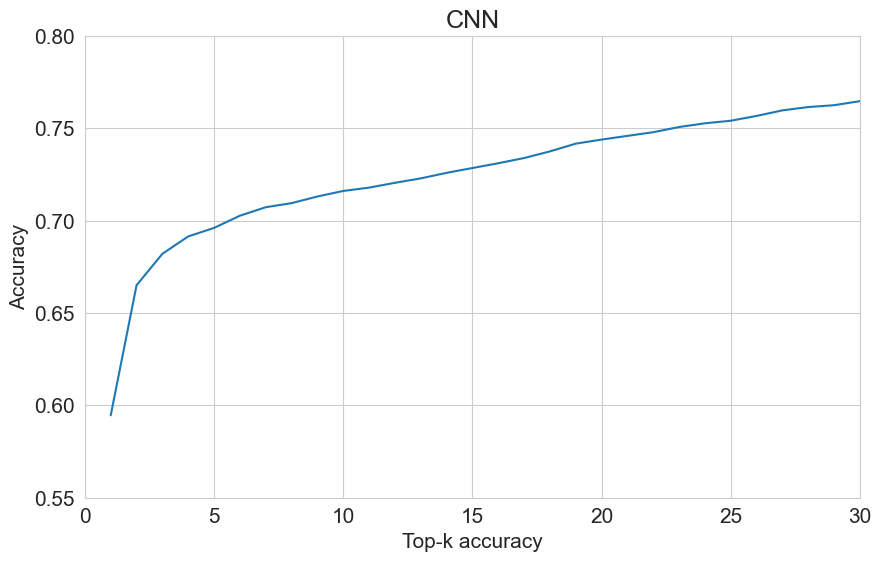

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlim(0, 30)
plt.ylim(0.55, 0.8)
plt.title('CNN')
plt.xlabel('Top-k accuracy')
plt.ylabel('Accuracy')
plt.savefig('cnn_topk_accuracy.png')

# Предобученный ImageNet_Mobile

In [26]:
a, p = [], []
ckpt = torch.load('fruit_mobilenet_w_long_calc.pt')

model = mobilenet_v2()
model.classifier[1] = torch.nn.Linear(1280, len(test_dataset.classes))

criterion = torch.nn.CrossEntropyLoss()
model.load_state_dict(ckpt['model'])
model.eval()

for images, labels in tqdm(test_loader, desc="test"):
    logits = model(images)
    
    a += labels.tolist()
    p.append([])
    for _ in range(30):
        p[-1].append(logits.argmax().item())
        logits = torch.Tensor(np.delete(logits.detach().numpy().astype(dtype=np.int32), logits.argmax().item()))

test:   0%|          | 0/5000 [00:00<?, ?it/s]

In [27]:
x, y = [], []
for k in range(30):
    x.append(k+1)
    p1 = []
    for i in range(len(a)):
        if a[i] in p[i][:k+1]:
            p1.append(a[i])
        else:
            p1.append(p[i][0])
    a1 = np.array(a)
    p1 = np.array(p1)
    c = a1 - p1
    for i in range(len(c)):
        if c[i] == 0:
            c[i] = 1
        else:
            c[i] = 0
    y.append(c.sum() / len(c))

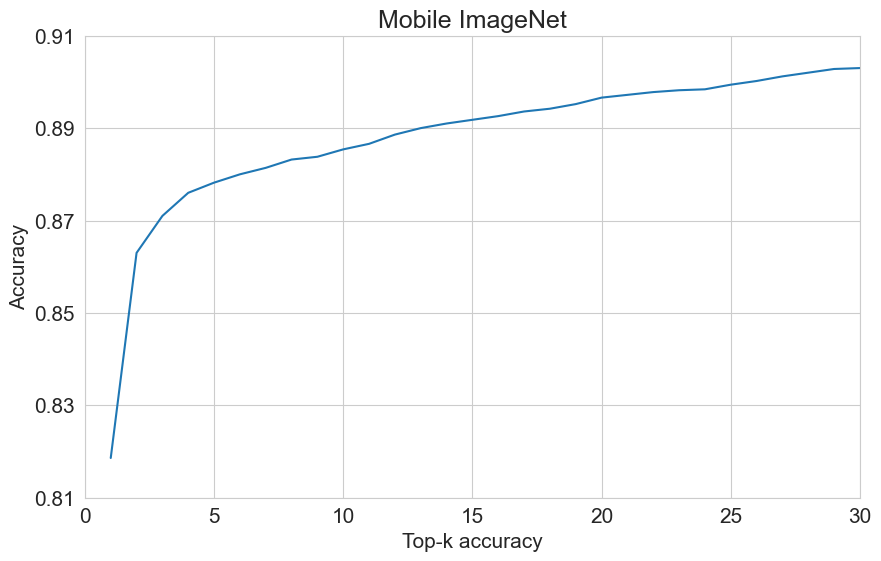

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.xlim(0, 30)
plt.ylim(0.81, 0.91)
plt.yticks([0.81, 0.83, 0.85, 0.87, 0.89, 0.91])
plt.title('Mobile ImageNet')
plt.xlabel('Top-k accuracy')
plt.ylabel('Accuracy')
plt.savefig('Imagenet_topk_accuracy.png')